# feature selection based on the synthetic.py data_generation

## get data

In [1]:
import tensorflow as tf
import numpy as np
from synthetic import generateData
import matplotlib.pyplot as plt

x_train, y_train, Kva, Kve, beta = generateData(60, 80, 10, 2, 5, 0.5, 0.5)

(80, 5)
118.0


synthetic.py:231: RuntimeWarning: covariance is not positive-semidefinite.
  yK_ = np.random.multivariate_normal(ypheno[:, i], sigC * C1, size=1)


In [2]:
n_input = 80
n_class = 5

n_hidden_1 = 50
n_hidden_2 = 5

learning_rate = 0.001

batch_size = 100
display_step = 1
training_epochs = 50000

#lasso loss
Alpha = 0.5

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_class])

## lasso weight matrix & bias

In [3]:
diag_random = np.random.normal(0, 0.1, n_input)
Ma_diag = np.diag(diag_random)
weight_lasso = tf.Variable(Ma_diag)
weight_lasso = tf.cast(weight_lasso, tf.float32)

bias_lasso = tf.Variable(tf.random_normal([n_input]))
output_lasso = tf.add(tf.matmul(x, weight_lasso), bias_lasso)

layer_0 = tf.nn.relu(output_lasso)

## add layer function

In [4]:
def add_layer(inputs, a, b, act_Fun = None):
    
    weight = tf.cast(tf.Variable(tf.random_normal([a, b])), tf.float32)
    bias = tf.Variable(tf.random_normal([b]))
    yy = tf.add(tf.matmul(inputs, weight), bias)
    
    if act_Fun is None:
        output = yy        
    else:
        output = act_Fun(yy)
    
    return output

def multiplayer_perceptron(first_in):
    
    layer_1 = add_layer(first_in, n_input, n_hidden_1, act_Fun = tf.nn.relu)
    
    layer_2 = add_layer(layer_1, n_hidden_1, n_hidden_2, act_Fun = tf.nn.relu)

    out_layer = add_layer(layer_2, n_hidden_2, n_class, act_Fun = tf.nn.softmax) 
    #act_Fun not softmax if use tf.nn.softmax_cross_entropy_with_logits
    
    return out_layer

pred = multiplayer_perceptron(layer_0)

In [5]:
#cal the sum of lasso M
sess_1 = tf.Session()
init_op=tf.global_variables_initializer()
sess_1.run(init_op)
weight_lasso = sess_1.run(weight_lasso)
weight_lasso_sum = sum(map(sum,weight_lasso))

loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred),1) + Alpha * weight_lasso_sum) 
optimize = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_loss = np.zeros(training_epochs)
train_acc = np.zeros(training_epochs)

In [11]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
     
    step = 1
    while step * batch_size < training_epochs:
        
        sess.run(optimize, feed_dict = {x: x_train, y: y_train})
        
        if step % display_step == 0:
            
            los, acc = sess.run([loss, accuracy], feed_dict={x: x_train, y: y_train})
            
            train_loss[step * batch_size] = los
            train_acc[step * batch_size] = acc
            
            print("step: %d  loss: %.9f  TRAIN_ACCURACY: %.3f"  % (step, los, acc))
            
            print "********************************************"
            
        step = step + 1
    
    
    print "完成！！！！！"

step: 1  loss: 98589.773437500  TRAIN_ACCURACY: 0.233
********************************************
step: 2  loss: 74597.031250000  TRAIN_ACCURACY: 0.100
********************************************
step: 3  loss: 69838.078125000  TRAIN_ACCURACY: 0.083
********************************************
step: 4  loss: 47161.648437500  TRAIN_ACCURACY: 0.083
********************************************
step: 5  loss: 27032.318359375  TRAIN_ACCURACY: 0.100
********************************************
step: 6  loss: 24250.460937500  TRAIN_ACCURACY: 0.117
********************************************
step: 7  loss: 20969.583984375  TRAIN_ACCURACY: 0.100
********************************************
step: 8  loss: 15299.310546875  TRAIN_ACCURACY: 0.067
********************************************
step: 9  loss: 11850.787109375  TRAIN_ACCURACY: 0.050
********************************************
step: 10  loss: 11071.806640625  TRAIN_ACCURACY: 0.017
********************************************
step: 11 

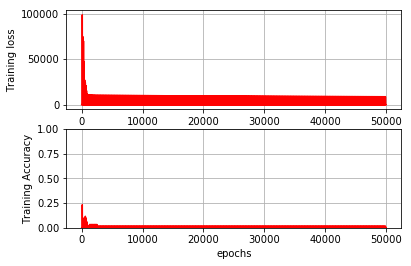

In [12]:
plt.subplot(211)
plt.plot(train_loss, 'r')
plt.xlabel("epochs")
plt.ylabel("Training loss")
plt.grid(True)


plt.subplot(212)
plt.xlabel("epochs")
plt.ylabel('Training Accuracy')
plt.ylim(0.0, 1)
plt.plot(train_acc, 'r')
plt.grid(True)

plt.show()